In [0]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# RNN Issue

In [0]:
N = 2  # batch size
H = 3  # hidden vector's dimension
T = 20 # time seqence length

## Gradient Exploding

In [0]:
dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh ** 2)) / N
  norm_list.append(norm)

Text(0, 0.5, 'norm')

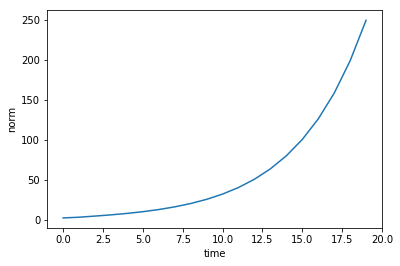

In [0]:
plt.plot(norm_list)
plt.xlim(-1, 20)
plt.xlabel('time')
plt.ylabel('norm')

## Gradient vanishing

In [0]:
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T)
  norm = np.sqrt(np.sum(dh ** 2)) / N
  norm_list.append(norm)

Text(0, 0.5, 'norm')

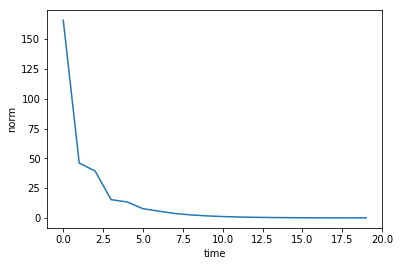

In [0]:
plt.plot(norm_list)
plt.xlim(-1, 20)
plt.xlabel('time')
plt.ylabel('norm')

## Gradients Clipping Solves Gradient Exploding

In [0]:
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

In [0]:
grads

[array([[2.83525082, 6.93137918, 4.40453718],
        [1.56867738, 5.44649018, 7.80314765],
        [3.06363532, 2.21957884, 3.87971258]]),
 array([[9.3638365 , 9.75995422, 6.72383676],
        [9.02834109, 8.45750871, 3.77994041],
        [0.92217009, 6.53410903, 5.57840762]])]

In [0]:
def clip_grads(grads, max_norm):
  total_norm = 0
  
  for grad in grads:
    total_norm += np.sum(grad ** 2)
    
  total_norm = np.sqrt(total_norm)
  rate = max_norm / (total_norm + 1e-6)
  
  if rate < 1:
    for grad in grads:
      grad *= rate

In [0]:
clip_grads(grads, max_norm)

In [0]:
grads

[array([[0.54849516, 1.34091414, 0.85208239],
        [0.30346943, 1.05365404, 1.50956263],
        [0.59267742, 0.42938996, 0.75055213]]),
 array([[1.81148663, 1.88811783, 1.30076389],
        [1.74658316, 1.63615244, 0.73125065],
        [0.17839897, 1.26406   , 1.07917421]])]

# Gated RNN (Solving Gradient Vanishing)

## LSTM

In [4]:
%cd /content/gdrive/My\ Drive/deep_learning_from_scratch
!ls -a

/content/gdrive/My Drive/deep_learning_from_scratch
0_Basis.ipynb				    8_AdvancedLearning.ipynb
10_deeplearning.ipynb			    9_CNN.ipynb
11_ParagraphSummary.ipynb		    common
12_NatureLanguage_WordRepresentation.ipynb  dataset
13_Word2Vec.ipynb			    ._.DS_Store
14_Word2Vec_Adv.ipynb			    .DS_Store
15_RNN.ipynb				    .git
16_GatedRNN.ipynb			    .gitignore
17_Seq2Seq.ipynb			    ._.gitignore
1_mlp.ipynb				    GoogleDrive_.ipynb
2_NeuralNetwork.ipynb			    .ipynb_checkpoints
3_MNIST_NeuralNetwork.ipynb		    network
4_nn_learning.ipynb			    ._README.md
5_NN_Learning_Assembly.ipynb		    README.md
6_MNIST_BatchTraining.ipynb		    tmp
7_Backpropagation.ipynb


In [0]:
from common.functions import sigmoid
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss

In [0]:
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None
    
  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
    
    # slice
    # f,g,i,o sizes are equal (N x H)
    f = A[:, :H]
    g = A[:, H:H*2]
    i = A[:, H*2:H*3]
    o = A[:, H*3:]
    
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    
    c_next = c_prev * f + g * i
    h_next = o * np.tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next
  
  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
    tanh_c_next = np.tanh(c_next)
    
    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
    
    dc_prev = ds * f
    
    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i
    
    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)
    
    dA = np.hstack((df, dg, di, do))
    
    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)
    
    return dx, dh_prev, dc_prev

## TimeLSTM

In [0]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = []
    
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful
  
  def forward(self, xs):
    """xs : N x T x D"""
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]
    
    self.layers = []
    hs = np.empty((N, T, H), dtype='f')
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')
      
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
      hs[:,t,:] = self.h
      self.layers.append(layer)
    
    print("size: {}".format(T))
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]
    
    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0
    
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
      dxs[:,t,:] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
        
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    
    return dxs
  
  def set_state(self, h, c=None):
    self.h, self.c = h, c
    
  def reset_state(self):
    self.h, self.c = None, None

# LSTM in Language Model

In [0]:
import pickle

In [0]:
class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    
    # initializing weights
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')
    
    # generate each layers
    self.layers = [
        TimeEmbedding(embed_W),
        TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]
    
    # gather all weights and gradients
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
      
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.lstm_layer.reset_state()
    
  def save_params(self, file_name="Rnnlm.pkl"):
    with open(file_name, "wb") as fout:
      pickle.dump(self.params, fout)
      
  def load_params(self, file_name="Rnnlm.pkl"):
    with open(file_name, "rb") as fin:
      self.params = pickle.load(fin)

In [0]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

## Hyperparameters and Loading Datasets

In [0]:
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [0]:
corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_test, _, _ = ptb.load_data("test")
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

## Generate a Model for Training

In [0]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model=model, optimizer=optimizer)

In [0]:
trainer.fit(xs, ts, max_epoch=max_epoch, batch_size=batch_size, time_size=time_size,
            max_grad=max_grad, eval_interval=40)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9998.30
| epoch 1 |  iter 41 / 1327 | time 17[s] | perplexity 1858.15
| epoch 1 |  iter 81 / 1327 | time 33[s] | perplexity 881.21
| epoch 1 |  iter 121 / 1327 | time 49[s] | perplexity 673.71
| epoch 1 |  iter 161 / 1327 | time 64[s] | perplexity 594.00
| epoch 1 |  iter 201 / 1327 | time 80[s] | perplexity 548.17
| epoch 1 |  iter 241 / 1327 | time 96[s] | perplexity 472.56
| epoch 1 |  iter 281 / 1327 | time 112[s] | perplexity 461.72
| epoch 1 |  iter 321 / 1327 | time 128[s] | perplexity 367.88
| epoch 1 |  iter 361 / 1327 | time 143[s] | perplexity 406.65
| epoch 1 |  iter 401 / 1327 | time 159[s] | perplexity 338.64
| epoch 1 |  iter 441 / 1327 | time 175[s] | perplexity 338.73
| epoch 1 |  iter 481 / 1327 | time 191[s] | perplexity 315.13
| epoch 1 |  iter 521 / 1327 | time 206[s] | perplexity 303.85
| epoch 1 |  iter 561 / 1327 | time 222[s] | perplexity 299.36
| epoch 1 |  iter 601 / 1327 | time 237[s] | perplexity 292.35
| 

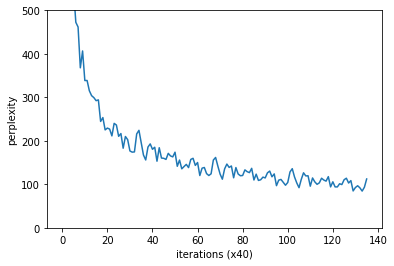

In [0]:
trainer.plot(ylim=(0, 500))

## Evaluation

In [0]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test, batch_size=batch_size, time_size=time_size)
print("Test Perplexity: {}".format(ppl_test))

In [0]:
model.save_params(file_name="./tmp/Rnnlm.pkl")

# Advanced RNNLM

In [0]:
from common.time_layers import TimeEmbedding, TimeDropout, TimeAffine, TimeSoftmaxWithLoss
from common.base_model import BaseModel

In [0]:
class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, 
               hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    
    # initializing weight
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')
    
    # generating layers
    self.layers = [
        TimeEmbedding(embed_W),
        TimeDropout(dropout_ratio),
        TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
        TimeDropout(dropout_ratio),
        TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
        TimeDropout(dropout_ratio),
        TimeAffine(embed_W.T, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
    
    # gathering weights and gradients
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, xs, train_flag=False):
    for layer in self.drop_layers:
      layer.train_flg = train_flag
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts, train_flag=True):
    score = self.predict(xs, train_flag)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()

## Training

In [0]:
from common.np import *
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

In [0]:
# hyperparameters
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.5
dropout = 0.5

In [0]:
# load datasets
corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_test, _, _ = ptb.load_data("test")
corpus_val, _, _ = ptb.load_data("val")

In [8]:
corpus.shape

(929589,)

In [0]:
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [0]:
# generate a model for training
model = BetterRnnlm(vocab_size=vocab_size, wordvec_size=wordvec_size, 
               hidden_size=hidden_size, dropout_ratio=dropout)
optimizer = SGD(lr)

In [0]:
trainer = RnnlmTrainer(model, optimizer)

In [0]:
best_ppl = float('inf')
for epoch in range(max_epoch):
  # training
  trainer.fit(xs, ts, max_epoch=max_epoch, batch_size=batch_size, 
              time_size=time_size, max_grad=max_grad, eval_interval=40)
  
  # perplexity
  model.reset_state()
  ppl = eval_perplexity(model, corpus, batch_size=batch_size, time_size=time_size)
  print('Perplexity: {}'.format(ppl))
  
  if best_ppl > ppl:
    best_ppl = ppl
    model.save_params()
  else:
    lr /= 4.0
    optimizer.lr = lr
    
  model.reset_state()
  print('-' * 50)

| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 9999.75
| epoch 1 |  iter 41 / 1327 | time 144[s] | perplexity 8008.66
| epoch 1 |  iter 81 / 1327 | time 284[s] | perplexity 1025.95
| epoch 1 |  iter 121 / 1327 | time 424[s] | perplexity 852.41
| epoch 1 |  iter 161 / 1327 | time 563[s] | perplexity 704.49
| epoch 1 |  iter 201 / 1327 | time 702[s] | perplexity 643.39
| epoch 1 |  iter 241 / 1327 | time 842[s] | perplexity 566.82
| epoch 1 |  iter 281 / 1327 | time 982[s] | perplexity 548.11
| epoch 1 |  iter 321 / 1327 | time 1123[s] | perplexity 436.10
| epoch 1 |  iter 361 / 1327 | time 1262[s] | perplexity 474.95
| epoch 1 |  iter 401 / 1327 | time 1402[s] | perplexity 407.77
| epoch 1 |  iter 441 / 1327 | time 1542[s] | perplexity 397.06
| epoch 1 |  iter 481 / 1327 | time 1681[s] | perplexity 370.24
| epoch 1 |  iter 521 / 1327 | time 1821[s] | perplexity 352.87
| epoch 1 |  iter 561 / 1327 | time 1961[s] | perplexity 347.35
| epoch 1 |  iter 601 / 1327 | time 2102[s] | perpl